## Regression 2: Removing Outliers and Adding in Weather Data
Since min_gap seems to be the only strong predictor variable in the other regression models, we'll attempt to remove the outliers and test with weather variables (temperature and precipitation) as additional independent variables.

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

In [ ]:
# Import weather data
# Get list of all weather csv files in the specified directory
weather_csv_files = glob.glob("weather_data/*.csv")
weather_csv_files

# Define the columns to use from the weather data
columns_to_use = ["Date/Time (LST)", "Temp (°C)", "Precip. Amount (mm)"]

# Read and concatenate all weather data into a single DataFrame
weather_data = pd.concat(
    [pd.read_csv(file, usecols=columns_to_use) for file in weather_csv_files],
    ignore_index=True
)
# Convert 'Date/Time (LST)' to datetime format
weather_data["Date/Time (LST)"] = pd.to_datetime(weather_data["Date/Time (LST)"])

# Display the first few rows of the weather data
weather_data.head()

,Date/Time (LST),Temp (°C),Precip. Amount (mm)
0,2024-01-01 00:00:00,-0.7,0.2
1,2024-01-01 01:00:00,-0.9,0.3
2,2024-01-01 02:00:00,-1.5,0.1
3,2024-01-01 03:00:00,-1.5,0.1
4,2024-01-01 04:00:00,-1.8,0.0


In [ ]:
# Extract year, month, day, hour from the datetime column
weather_data["year"] = weather_data["Date/Time (LST)"].dt.year
weather_data["month"] = weather_data["Date/Time (LST)"].dt.month
weather_data["day"] = weather_data["Date/Time (LST)"].dt.day
weather_data["hour"] = weather_data["Date/Time (LST)"].dt.hour

weather_data.head()

,Date/Time (LST),Temp (°C),Precip. Amount (mm),year,month,day,hour
0,2024-01-01 00:00:00,-0.7,0.2,2024,1,1,0
1,2024-01-01 01:00:00,-0.9,0.3,2024,1,1,1
2,2024-01-01 02:00:00,-1.5,0.1,2024,1,1,2
3,2024-01-01 03:00:00,-1.5,0.1,2024,1,1,3
4,2024-01-01 04:00:00,-1.8,0.0,2024,1,1,4


In [4]:
# Load ttc streetcar delay dataset
ttc_data = pd.read_csv("ttc-streetcar-delay-data-2024_cleaned.csv")

In [ ]:
# Remove outliers from streetcar delay data based on Min Delay using the 1.5*IQR rule
# Calculate Q1, Q3, IQR, and bounds
Median = ttc_data["Min Delay"].median()
Q1 = ttc_data["Min Delay"].quantile(0.25)
Q3 = ttc_data["Min Delay"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(Q1 - 1.5 * IQR,0) # replace negative lower bound with 0
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
ttc_no_outliers = ttc_data[(ttc_data["Min Delay"] >= lower_bound) & (ttc_data["Min Delay"] <= upper_bound)]
ttc_no_outliers

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
2,28-Jan-24,301.0,02:11,Sunday,WARDEN AND COMSTOCK,Mechanical,10.0,20.0,W,8734.0,1.0,5.0,28.0,2.0,Winter
3,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall
4,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer
5,15-May-24,301.0,02:42,Wednesday,SUNNYSIDE LOOP,Security,0.0,0.0,NaN,4589.0,5.0,20.0,15.0,2.0,Spring
6,3-Jul-24,301.0,03:49,Wednesday,SUNNYSIDE LOOP,Emergency Services,20.0,40.0,W,4491.0,7.0,27.0,3.0,3.0,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,22-Apr-24,512.0,15:38,Monday,AND OAKWOOD,General Delay,0.0,0.0,W,7006.0,4.0,17.0,22.0,15.0,Spring
13920,18-Feb-24,512.0,19:50,Sunday,AND KEELE,Operations,8.0,15.0,E,8337.0,2.0,8.0,18.0,19.0,Winter
13921,19-Apr-24,512.0,20:24,Friday,AND GLENHOLME,Mechanical,10.0,20.0,W,8799.0,4.0,16.0,19.0,20.0,Spring
13922,20-Feb-24,512.0,16:20,Tuesday,AND EARLS COU,Collision - TTC Involved,4.0,8.0,E,8295.0,2.0,8.0,20.0,16.0,Winter


In [ ]:
# Remove outliers from Location column based on if they appear less than 5 times in the dataframe as these locations are likely to be typos or rare events
location_counts = ttc_no_outliers['Location'].value_counts()
locations_to_keep = location_counts[location_counts >= 5].index

# Filter the dataframe to keep only locations that appear 5 or more times
ttc_no_outliers = ttc_no_outliers[ttc_no_outliers['Location'].isin(locations_to_keep)]
ttc_no_outliers

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
3,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall
4,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer
5,15-May-24,301.0,02:42,Wednesday,SUNNYSIDE LOOP,Security,0.0,0.0,NaN,4589.0,5.0,20.0,15.0,2.0,Spring
6,3-Jul-24,301.0,03:49,Wednesday,SUNNYSIDE LOOP,Emergency Services,20.0,40.0,W,4491.0,7.0,27.0,3.0,3.0,Summer
7,9-Nov-24,301.0,06:51,Saturday,SUNNYSIDE LOOP,Emergency Services,0.0,0.0,NaN,4591.0,11.0,45.0,9.0,6.0,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13892,25-Nov-24,512.0,15:38,Monday,BATHURST AND ST CLAIR,Emergency Services,11.0,19.0,W,4521.0,11.0,48.0,25.0,15.0,Fall
13893,12-Dec-24,512.0,06:25,Thursday,BATHURST AND ST CLAIR,Held By,19.0,28.0,E,4403.0,12.0,50.0,12.0,6.0,Fall
13894,31-Dec-24,512.0,07:16,Tuesday,BATHURST AND ST CLAIR,Rail/Switches,7.0,15.0,N,4454.0,12.0,53.0,31.0,7.0,Winter
13895,21-Nov-24,512.0,18:44,Thursday,BATHURST AND ST CLAIR,Cleaning - Unsanitary,8.0,16.0,W,4436.0,11.0,47.0,21.0,18.0,Fall


In [ ]:
# Add weekday column to dataset to define if it's a weekday or weekend
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Create boolean columns: True if weekday, False if weekend
ttc_no_outliers['Weekday'] = ttc_no_outliers['Day'].isin(weekdays)
ttc_no_outliers.rename(columns={'Day': 'Day of Week'}) # Rename column for clarity (day of month column will be renamed to match weather dataset)

C:\Users\natas\AppData\Local\Temp\ipykernel_18332\3315935108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttc_no_outliers['Weekday'] = ttc_no_outliers['Day'].isin(weekdays)


,Date,Line,Time,Day of Week,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season,Weekday
3,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall,True
4,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer,False
5,15-May-24,301.0,02:42,Wednesday,SUNNYSIDE LOOP,Security,0.0,0.0,NaN,4589.0,5.0,20.0,15.0,2.0,Spring,True
6,3-Jul-24,301.0,03:49,Wednesday,SUNNYSIDE LOOP,Emergency Services,20.0,40.0,W,4491.0,7.0,27.0,3.0,3.0,Summer,True
7,9-Nov-24,301.0,06:51,Saturday,SUNNYSIDE LOOP,Emergency Services,0.0,0.0,NaN,4591.0,11.0,45.0,9.0,6.0,Fall,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13892,25-Nov-24,512.0,15:38,Monday,BATHURST AND ST CLAIR,Emergency Services,11.0,19.0,W,4521.0,11.0,48.0,25.0,15.0,Fall,True
13893,12-Dec-24,512.0,06:25,Thursday,BATHURST AND ST CLAIR,Held By,19.0,28.0,E,4403.0,12.0,50.0,12.0,6.0,Fall,True
13894,31-Dec-24,512.0,07:16,Tuesday,BATHURST AND ST CLAIR,Rail/Switches,7.0,15.0,N,4454.0,12.0,53.0,31.0,7.0,Winter,True
13895,21-Nov-24,512.0,18:44,Thursday,BATHURST AND ST CLAIR,Cleaning - Unsanitary,8.0,16.0,W,4436.0,11.0,47.0,21.0,18.0,Fall,True


In [ ]:
# Rename ttc dataset columns for merging
ttc_no_outliers = ttc_no_outliers.rename(columns={"Year": "year", "Month": "month", "Day of Month": "day", "Hour of Day": "hour"})
ttc_no_outliers.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,month,Week,day,hour,Season,Weekday
3,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall,True
4,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer,False
5,15-May-24,301.0,02:42,Wednesday,SUNNYSIDE LOOP,Security,0.0,0.0,NaN,4589.0,5.0,20.0,15.0,2.0,Spring,True
6,3-Jul-24,301.0,03:49,Wednesday,SUNNYSIDE LOOP,Emergency Services,20.0,40.0,W,4491.0,7.0,27.0,3.0,3.0,Summer,True
7,9-Nov-24,301.0,06:51,Saturday,SUNNYSIDE LOOP,Emergency Services,0.0,0.0,NaN,4591.0,11.0,45.0,9.0,6.0,Fall,False


In [ ]:
# Merge data frames and drop unnecessary columns
ttc_weather = pd.merge(ttc_no_outliers, weather_data, on=["month", "day", "hour"], how="left")
ttc_weather.drop(columns=["Date/Time (LST)", "year"], inplace=True)
ttc_weather.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,month,Week,day,hour,Season,Weekday,Temp (°C),Precip. Amount (mm)
0,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall,True,6.9,0.0
1,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer,False,18.5,0.0
2,15-May-24,301.0,02:42,Wednesday,SUNNYSIDE LOOP,Security,0.0,0.0,NaN,4589.0,5.0,20.0,15.0,2.0,Spring,True,14.0,0.0
3,3-Jul-24,301.0,03:49,Wednesday,SUNNYSIDE LOOP,Emergency Services,20.0,40.0,W,4491.0,7.0,27.0,3.0,3.0,Summer,True,20.8,0.0
4,9-Nov-24,301.0,06:51,Saturday,SUNNYSIDE LOOP,Emergency Services,0.0,0.0,NaN,4591.0,11.0,45.0,9.0,6.0,Fall,False,2.8,0.0


In [ ]:
# One-hot encode location and incident columns
# Drop unnecessary columns for correlation analysis
location_encoded = pd.get_dummies(ttc_weather['Location'], prefix='Location')
incident_encoded = pd.get_dummies(ttc_weather['Incident'], prefix='Incident')
ttc_weather_corr = pd.concat([ttc_weather, location_encoded, incident_encoded], axis=1)
ttc_weather_corr.drop(columns=['Location', 'Incident', 'Date', 'Time', 'Day', 'Bound', 'Vehicle', 'Season'], inplace=True)
ttc_weather_corr

,Line,Min Delay,Min Gap,month,Week,day,hour,Weekday,Temp (°C),Precip. Amount (mm),...,Incident_Emergency Services,Incident_General Delay,Incident_Held By,Incident_Investigation,Incident_Mechanical,Incident_Operations,Incident_Overhead,Incident_Rail/Switches,Incident_Security,Incident_Utilized Off Route
0,301.0,24.0,39.0,11.0,46.0,15.0,2.0,True,6.9,0.0,...,False,False,False,False,False,False,False,False,True,False
1,301.0,10.0,30.0,8.0,35.0,25.0,3.0,False,18.5,0.0,...,False,False,False,False,True,False,False,False,False,False
2,301.0,0.0,0.0,5.0,20.0,15.0,2.0,True,14.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,301.0,20.0,40.0,7.0,27.0,3.0,3.0,True,20.8,0.0,...,True,False,False,False,False,False,False,False,False,False
4,301.0,0.0,0.0,11.0,45.0,9.0,6.0,False,2.8,0.0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10573,512.0,11.0,19.0,11.0,48.0,25.0,15.0,True,5.2,0.0,...,True,False,False,False,False,False,False,False,False,False
10574,512.0,19.0,28.0,12.0,50.0,12.0,6.0,True,-3.4,0.0,...,False,False,True,False,False,False,False,False,False,False
10575,512.0,7.0,15.0,12.0,53.0,31.0,7.0,True,0.9,0.0,...,False,False,False,False,False,False,False,True,False,False
10576,512.0,8.0,16.0,11.0,47.0,21.0,18.0,True,5.2,0.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Calculate correlation matrix and select features with strong correlation to Min Delay
corr_matrix = ttc_weather_corr.corr()
strong_features = corr_matrix["Min Delay"].abs()
strong_features = strong_features[strong_features > 0.2].index.tolist()
pairplot_df = ttc_weather_corr[strong_features]

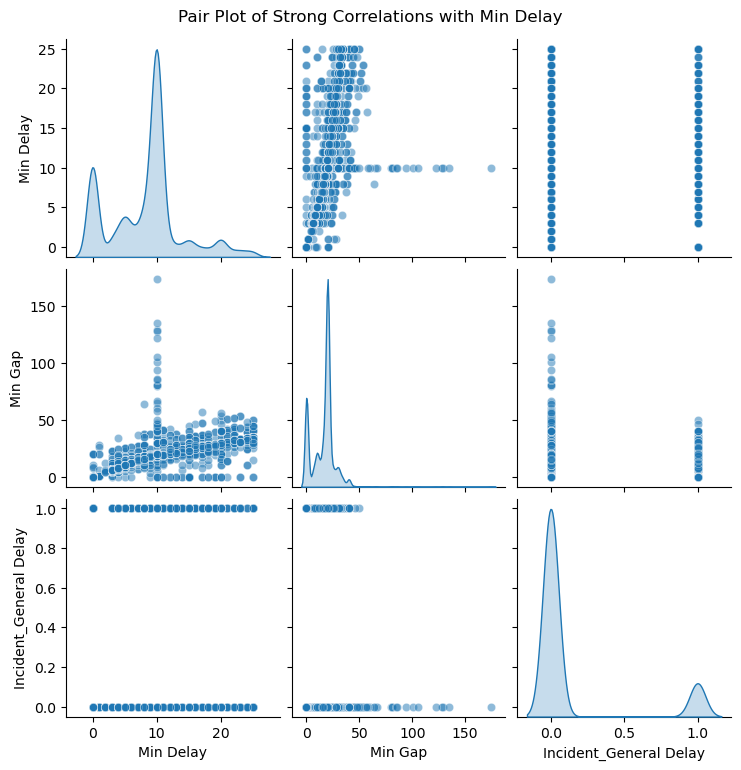

In [ ]:
# Create pair plot for features with strong correlation to Min Delay
sns.pairplot(pairplot_df, kind="scatter", diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Pair Plot of Strong Correlations with Min Delay", y=1.02)
plt.show()

Analysis: The above plot shows the features that have a correlation of > abs(0.2) (which is a very low threshold to classify as a 'strong' correlation) - only minute gap and incident general delay have any significance. The weather data does not seem correlated at all to minute delay.

Let's try looking at General Delays only, to see if there's some correlations we can see.

In [ ]:
# Select general delays only for further analysis
general_delays = ttc_weather["Incident"] == "General Delay"
ttc_weather_general = ttc_weather[general_delays]
ttc_weather_general

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,month,Week,day,hour,Season,Weekday,Temp (°C),Precip. Amount (mm)
15,13-Apr-24,301.0,02:26,Saturday,QUEEN AND SAULTER,General Delay,0.0,0.0,E,4450.0,4.0,15.0,13.0,2.0,Spring,False,5.0,0.4
46,2-Sep-24,301.0,02:31,Monday,QUEEN AND BROADVIEW,General Delay,10.0,30.0,E,4584.0,9.0,36.0,2.0,2.0,Summer,True,15.2,0.0
56,6-Sep-24,301.0,01:36,Friday,MCCAUL AND QUEEN,General Delay,22.0,32.0,N,4583.0,9.0,36.0,6.0,1.0,Summer,True,20.4,0.0
58,30-Sep-24,301.0,03:32,Monday,LONG BRANCH LOOP,General Delay,0.0,0.0,NaN,0.0,9.0,40.0,30.0,3.0,Fall,True,17.9,0.0
67,3-Apr-24,301.0,03:02,Wednesday,LONG BRANCH LOOP,General Delay,0.0,0.0,E,4428.0,4.0,14.0,3.0,3.0,Spring,True,5.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10525,18-Oct-24,512.0,17:03,Friday,GUNNS LOOP,General Delay,18.0,26.0,E,4456.0,10.0,42.0,18.0,17.0,Fall,True,15.2,0.0
10527,8-Dec-24,512.0,15:49,Sunday,GUNNS LOOP,General Delay,4.0,12.0,E,4459.0,12.0,50.0,8.0,15.0,Fall,False,6.9,0.0
10566,22-Dec-24,512.0,07:07,Sunday,BATHURST STATION,General Delay,0.0,0.0,W,4482.0,12.0,52.0,22.0,7.0,Winter,False,-15.1,0.0
10568,30-Sep-24,512.0,04:23,Monday,BATHURST AND ST CLAIR,General Delay,0.0,0.0,N,4475.0,9.0,40.0,30.0,4.0,Fall,True,17.8,0.0


<Axes: >

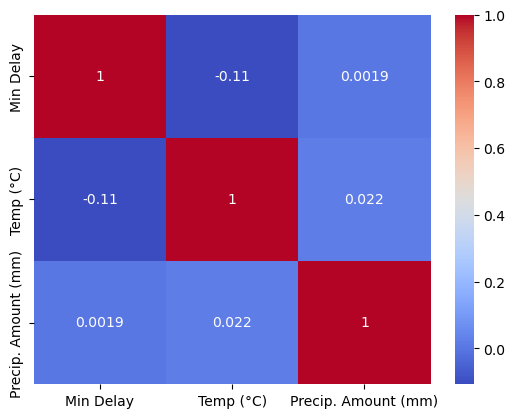

In [ ]:
# Look at correlation matrix for general delays only, for features: weekday, temp and precip amount
subset = ttc_weather_general[["Min Delay", "Temp (°C)", "Precip. Amount (mm)"]]
subset_corr = subset.corr()
sns.heatmap(subset_corr, annot=True, cmap="coolwarm")

The above correlation matrix shows a very weak negative correlation between temperature and minute delay.

In [ ]:
#  Fit linear regression model on Temp (°C) vs Min Delay for general delays only
ttc_weather_reg = ttc_weather_general.dropna(subset=["Temp (°C)", "Min Delay"])
model = LinearRegression()
model.fit(ttc_weather_reg[["Temp (°C)"]],ttc_weather_reg["Min Delay"])

LinearRegression()

In [16]:
# Find coefficients
coefficients = model.coef_
intercept = model.intercept_
coefficients, intercept

(array([-0.07040891]), np.float64(5.876638180456808))

In [ ]:
# predict using the model
predictions = model.predict(ttc_weather_reg[["Temp (°C)"]])

In [ ]:
# Evaluate model performance
mae = mean_absolute_error(ttc_weather_reg["Min Delay"], predictions)
mse = mean_squared_error(ttc_weather_reg["Min Delay"], predictions)
r2 = r2_score(ttc_weather_reg["Min Delay"], predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 5.54
MSE: 39.81
R²: 0.01


As expected, the R2 for this model shows no significance. Let's move on to classification!